In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import random
import json
from sklearn.preprocessing import StandardScaler

Set seeds

In [2]:
seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Prepare Data 


Additionally, visualize the data

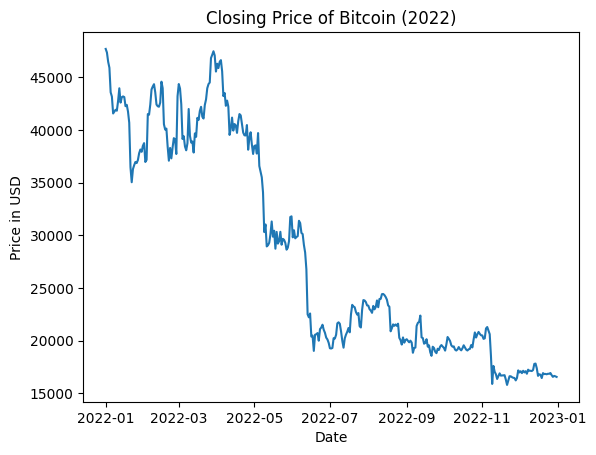

In [3]:
#Load in data
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

df = pd.read_csv(data_path)

ts = df["Close"].values


start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.savefig('graphs/bitcoin-price.png')
plt.show()

### Feature Scaling


In [4]:
print(ts.shape)

ts = ts.reshape(-1,1)
print(ts.shape)

(365,)
(365, 1)


In [5]:
print(ts.dtype)

ts = ts.astype(np.float32)

print(ts.dtype)

float64
float32


In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ts)

### Train-Validation-Test Split

Check dimensions

In [7]:
# train-valid-test split for time series
train_size = int(len(scaled_data) * 0.60)
train, rest = scaled_data[:train_size], scaled_data[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

219
73
73


### Create tensor dataset

In [8]:
def create_dataset(dataset, lookback):
    """
    Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

Inspect shape of tensors

In [9]:
print(f"X_train, y_train shape {X_train.shape, y_train.shape}")
print(f"X_valid, y_valid shape: {X_valid.shape, y_valid.shape}")
print(f"X_test, y_test shape: {X_test.shape, y_test.shape}")

X_train, y_train shape (torch.Size([218, 1, 1]), torch.Size([218, 1, 1]))
X_valid, y_valid shape: (torch.Size([72, 1, 1]), torch.Size([72, 1, 1]))
X_test, y_test shape: (torch.Size([72, 1, 1]), torch.Size([72, 1, 1]))


## LSTM Class


In [10]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=150, num_layers=1, batch_first=True)
        self.linear = nn.Linear(150, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1:, :])
        return x

## Training


In [11]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

#Training configuration
n_epochs = 1000
patience = 25
best_epoch = 0
best_valid_rmse = float('inf')
best_train_rmse = 0
patience_counter = 0

# Loss tracking
train_losses = []
valid_losses = []

for epoch in range(n_epochs+1):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    #Progress Printer
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
            
            y_pred = model(X_valid)
            valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid))

            train_losses.append(train_rmse.item())
            valid_losses.append(valid_rmse.item())
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")
    
    if train_rmse < 0.05:
        #Early stopping
        if valid_rmse < best_valid_rmse:
            best_epoch = epoch
            best_train_rmse = train_rmse
            best_valid_rmse = valid_rmse
            patience_counter = 0
        else:
            patience_counter += 1

        # Stop training if patience has been exceeded
        if patience_counter >= patience:
            print(f"Early stopping at Epoch {epoch}: The train RMSE {train_rmse:.4f}, best validation RMSE {best_valid_rmse:.4f}")
            break

Epoch 0: train RMSE 0.9977, validation RMSE 0.8160
Epoch 10: train RMSE 0.5277, validation RMSE 0.9484
Epoch 20: train RMSE 0.1488, validation RMSE 0.2072
Epoch 30: train RMSE 0.1241, validation RMSE 0.0753
Epoch 40: train RMSE 0.1226, validation RMSE 0.0734
Epoch 50: train RMSE 0.1213, validation RMSE 0.0682
Epoch 60: train RMSE 0.1204, validation RMSE 0.0630
Epoch 70: train RMSE 0.1198, validation RMSE 0.0617
Epoch 80: train RMSE 0.1193, validation RMSE 0.0603
Epoch 90: train RMSE 0.1190, validation RMSE 0.0589
Epoch 100: train RMSE 0.1189, validation RMSE 0.0574
Epoch 110: train RMSE 0.1188, validation RMSE 0.0574
Epoch 120: train RMSE 0.1188, validation RMSE 0.0578
Epoch 130: train RMSE 0.1188, validation RMSE 0.0571
Epoch 140: train RMSE 0.1187, validation RMSE 0.0568
Epoch 150: train RMSE 0.1187, validation RMSE 0.0566
Epoch 160: train RMSE 0.1188, validation RMSE 0.0568
Epoch 170: train RMSE 0.1188, validation RMSE 0.0577
Epoch 180: train RMSE 0.1188, validation RMSE 0.0574
Epoc

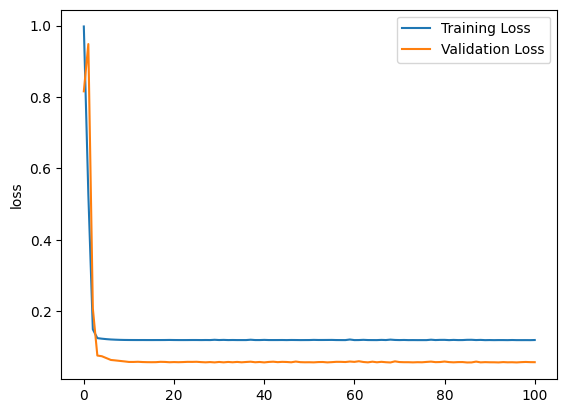

In [12]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylabel('loss')
plt.legend()
plt.savefig('graphs/train-validation-loss-lstm.png')
plt.show()

## Plotting Results of LSTM



In [13]:
og_train_set = scaler.inverse_transform(y_train.reshape(-1,1))
og_valid_set = scaler.inverse_transform(y_valid.reshape(-1,1))
og_test_set = scaler.inverse_transform(y_test.reshape(-1,1))

train RMSE 1210.2093, validation RMSE 577.3162, test RMSE 594.7331


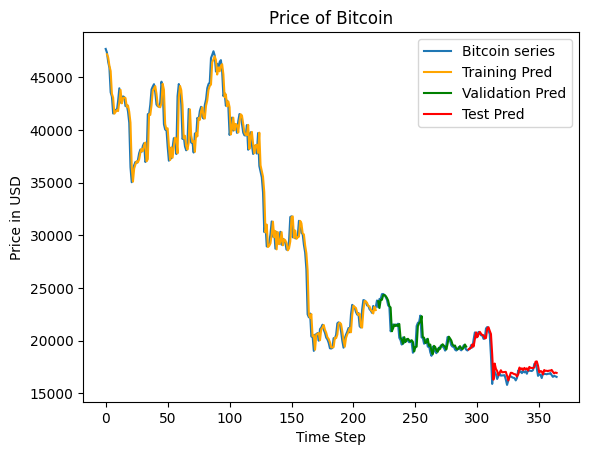

In [14]:
with torch.no_grad():
    train_pred = model(X_train).detach().numpy().reshape(-1,1)
    valid_pred = model(X_valid).detach().numpy().reshape(-1,1)
    test_pred = model(X_test).detach().numpy().reshape(-1,1)

#Shift train predictions for plotting
train_plot = np.ones_like(ts) * np.nan
valid_plot = np.ones_like(ts) * np.nan
test_plot = np.ones_like(ts) * np.nan

# Reverse scaling
og_train_pred = scaler.inverse_transform(train_pred)
og_valid_pred = scaler.inverse_transform(valid_pred)
og_test_pred = scaler.inverse_transform(test_pred)

rmse_train = np.sqrt(mean_squared_error(og_train_pred, og_train_set))
rmse_valid = np.sqrt(mean_squared_error(og_valid_pred, og_valid_set))
rmse_test = np.sqrt(mean_squared_error(og_test_pred, og_test_set))

print(f"train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}, test RMSE {rmse_test:.4f}")

train_plot[lookback:train_size] = og_train_pred
valid_plot[lookback+train_size:train_size+validation_size] = og_valid_pred
test_plot[lookback+train_size+validation_size:] = og_test_pred

# plot
plt.plot(ts, label='Bitcoin series')
plt.plot(train_plot, c='orange', label="Training Pred")
plt.plot(valid_plot, c='green', label='Validation Pred')
plt.plot(test_plot, c='r', label='Test Pred')
plt.xlabel('Time Step')
plt.ylabel('Price in USD')
plt.title('Price of Bitcoin')
plt.legend()
plt.savefig("collective-lstm-results.png")
plt.show()

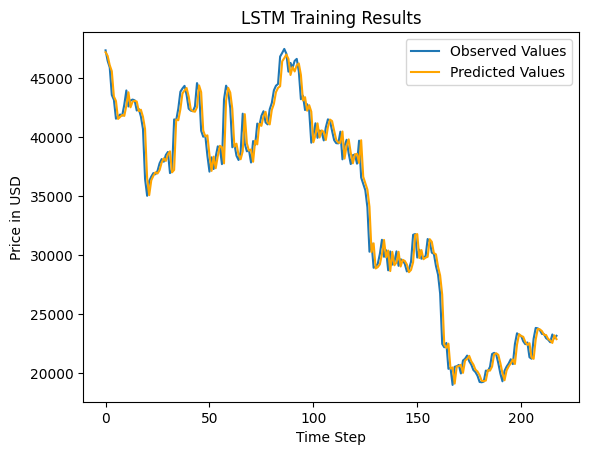

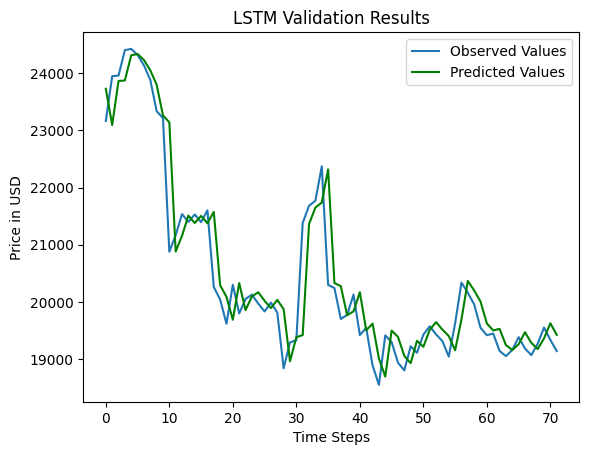

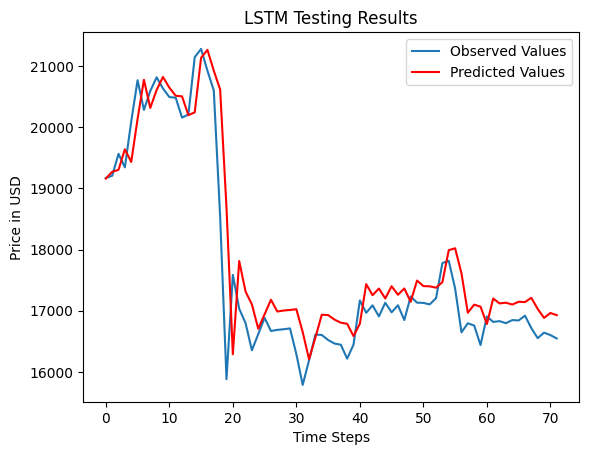

In [15]:
plt.plot(og_train_set, label="Observed Values")
plt.plot(og_train_pred, c='orange', label="Predicted Values")
plt.xlabel('Time Step')
plt.ylabel('Price in USD')
plt.title('LSTM Training Results')
plt.legend()
plt.savefig("graphs/lstm-training-results.png")
plt.show()

plt.plot(og_valid_set, label='Observed Values')
plt.plot(og_valid_pred, c='green', label='Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price in USD')
plt.title('LSTM Validation Results')
plt.legend()
plt.savefig('graphs/lstm-validation-results.png')
plt.show()

plt.plot(og_test_set, label='Observed Values')
plt.plot(og_test_pred, c='red', label='Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price in USD')
plt.title('LSTM Testing Results')
plt.legend()
plt.savefig('graphs/lstm-testing-results.png')
plt.show()
